# Project Title
### Data Engineering Capstone Project

#### Project Summary
--describe your project at a high level--

The project follows the follow steps:
* Step 1: Scope the Project and Gather Data
* Step 2: Explore and Assess the Data
* Step 3: Define the Data Model
* Step 4: Run ETL to Model the Data
* Step 5: Complete Project Write Up

In [55]:
# Do all imports and installs here
import pandas as pd
import os
import glob
import re
from datetime import datetime, timedelta
from pprint import pprint
from pyspark.sql import SparkSession
from pyspark.sql.functions import count, col, udf, year, month, avg, round, dayofweek, weekofyear, isnull
from pyspark.sql.types import StringType, IntegerType

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Create Spark session

spark = SparkSession.builder.\
config("spark.jars.repositories", "https://repos.spark-packages.org/").\
config("spark.jars.packages", "saurfang:spark-sas7bdat:2.0.0-s_2.11").\
enableHiveSupport().getOrCreate()

### Step 1: Scope the Project and Gather Data

#### Scope 
Explain what you plan to do in the project in more detail. What data do you use? What is your end solution look like? What tools did you use? etc>

#### Describe and Gather Data 
Describe the data sets you're using. Where did it come from? What type of information is included? 

In [3]:
immigration_files = glob.glob("../../data/18-83510-I94-Data-2016/*.sas7bdat")
immigration_files

['../../data/18-83510-I94-Data-2016/i94_apr16_sub.sas7bdat',
 '../../data/18-83510-I94-Data-2016/i94_sep16_sub.sas7bdat',
 '../../data/18-83510-I94-Data-2016/i94_nov16_sub.sas7bdat',
 '../../data/18-83510-I94-Data-2016/i94_mar16_sub.sas7bdat',
 '../../data/18-83510-I94-Data-2016/i94_jun16_sub.sas7bdat',
 '../../data/18-83510-I94-Data-2016/i94_aug16_sub.sas7bdat',
 '../../data/18-83510-I94-Data-2016/i94_may16_sub.sas7bdat',
 '../../data/18-83510-I94-Data-2016/i94_jan16_sub.sas7bdat',
 '../../data/18-83510-I94-Data-2016/i94_oct16_sub.sas7bdat',
 '../../data/18-83510-I94-Data-2016/i94_jul16_sub.sas7bdat',
 '../../data/18-83510-I94-Data-2016/i94_feb16_sub.sas7bdat',
 '../../data/18-83510-I94-Data-2016/i94_dec16_sub.sas7bdat']

In [13]:
# Read Immigration data here
# Assumption for the project: in this project only the i94_sep16_sub.sas7bdat will be used
immigration_file_name = "../../data/18-83510-I94-Data-2016/i94_sep16_sub.sas7bdat"
immigration_df = spark.read.format("com.github.saurfang.sas.spark").load(immigration_file_name)

In [20]:
immigration_df.limit(5).toPandas()

,cicid,i94yr,i94mon,i94cit,i94res,i94port,arrdate,i94mode,i94addr,depdate,...,entdepu,matflag,biryear,dtaddto,gender,insnum,airline,admnum,fltno,visatype
0,687.0,2016.0,9.0,213.0,213.0,HOU,20698.0,1.0,TX,20725.0,...,None,M,1989.0,11022016,M,None,QK,9.527939e+10,8111,B1
1,799.0,2016.0,9.0,369.0,369.0,WAS,20698.0,1.0,VA,20725.0,...,None,M,1945.0,11032016,M,None,KL,9.531093e+10,651,B2
2,1001.0,2016.0,9.0,582.0,582.0,LVG,20698.0,1.0,NV,20702.0,...,None,M,1991.0,10312016,M,None,4O,9.507648e+10,970,B2
3,1044.0,2016.0,9.0,691.0,582.0,MIA,20698.0,1.0,FL,20702.0,...,None,M,1966.0,11032016,M,None,AM,9.532965e+10,428,B1
4,1183.0,2016.0,9.0,266.0,266.0,CHI,20698.0,1.0,WI,20714.0,...,None,M,1982.0,D/S,F,None,UA,9.465594e+10,5959,F1


In [21]:
# Read the temperature data
temperature_file = "../../data2/GlobalLandTemperaturesByCity.csv"
temperature_df = spark.read.format("csv").option("delimiter", ",").option("header", "true").load(temperature_file)
temperature_df.limit(5).toPandas()

,dt,AverageTemperature,AverageTemperatureUncertainty,City,Country,Latitude,Longitude
0,1743-11-01,6.068,1.7369999999999999,Århus,Denmark,57.05N,10.33E
1,1743-12-01,None,None,Århus,Denmark,57.05N,10.33E
2,1744-01-01,None,None,Århus,Denmark,57.05N,10.33E
3,1744-02-01,None,None,Århus,Denmark,57.05N,10.33E
4,1744-03-01,None,None,Århus,Denmark,57.05N,10.33E


In [22]:
# Read demographics data
demo_file = "us-cities-demographics.csv"
demo_df = spark.read.format("csv").option("delimiter", ";").option("header", "true").load(demo_file)
demo_df.limit(5).toPandas()

,City,State,Median Age,Male Population,Female Population,Total Population,Number of Veterans,Foreign-born,Average Household Size,State Code,Race,Count
0,Silver Spring,Maryland,33.8,40601,41862,82463,1562,30908,2.6,MD,Hispanic or Latino,25924
1,Quincy,Massachusetts,41.0,44129,49500,93629,4147,32935,2.39,MA,White,58723
2,Hoover,Alabama,38.5,38040,46799,84839,4819,8229,2.58,AL,Asian,4759
3,Rancho Cucamonga,California,34.5,88127,87105,175232,5821,33878,3.18,CA,Black or African-American,24437
4,Newark,New Jersey,34.6,138040,143873,281913,5829,86253,2.73,NJ,White,76402


### Step 2: Explore and Assess the Data
#### Explore the Data 
Identify data quality issues, like missing values, duplicate data, etc.

#### Cleaning Steps
Document steps necessary to clean the data

### Immigration Data
#### 1 - Remove missing values
#### 2 - Validate the I94 address against Valid States, remove data for invalid States
#### 3 - Convert the Arrival date into valid date format

In [23]:
# Create list of valid states from demographies data
valid_states = demo_df.toPandas()["State Code"].unique()
print(valid_states)

['MD' 'MA' 'AL' 'CA' 'NJ' 'IL' 'AZ' 'MO' 'NC' 'PA' 'KS' 'FL' 'TX' 'VA' 'NV'
 'CO' 'MI' 'CT' 'MN' 'UT' 'AR' 'TN' 'OK' 'WA' 'NY' 'GA' 'NE' 'KY' 'SC' 'LA'
 'NM' 'IA' 'RI' 'PR' 'DC' 'WI' 'OR' 'NH' 'ND' 'DE' 'OH' 'ID' 'IN' 'AK' 'MS'
 'HI' 'SD' 'ME' 'MT']


In [24]:
# Create udf to convert SAS date to PySpark date 
@udf(StringType())
def convert_datetime(x):
    if x:
        return (datetime(1960, 1, 1).date() + timedelta(x)).isoformat()
    return None


In [25]:
# Create udf to validate state
@udf(StringType())
def validate_state(state):  
    if state in valid_states:
        return state
    return 'Invalid'

### Clean Immigration Data

In [27]:
# Remove any missing values
cleaned_immigration_df = immigration_df.dropna(how="any", subset=["i94port", "i94addr", "gender"])

# # Extract valid states 
cleaned_immigration_df = cleaned_immigration_df.withColumn("i94addr", validate_state(cleaned_immigration_df.i94addr))

# only keep us related immigration data
cleaned_immigration_df = cleaned_immigration_df.filter(cleaned_immigration_df.i94addr != 'Invalid')

# Convert arrival_date (SAS format) to PySpark format
cleaned_immigration_df = cleaned_immigration_df.withColumn("arrdate", convert_datetime(cleaned_immigration_df.arrdate))


staging_immigration_df = cleaned_immigration_df.select(col("cicid").alias("id"), 
                                       col("arrdate").alias("date"),
                                       col("i94port").alias("city_code"),
                                       col("i94addr").alias("state_code"),
                                       col("i94bir").alias("age"),
                                       col("gender").alias("gender"),
                                       col("visatype").alias("visa_type"),
                                       "count").drop_duplicates()


In [28]:
staging_immigration_df.limit(5).show()

+--------+----------+---------+----------+---+------+---------+-----+
|      id|      date|city_code|state_code|age|gender|visa_type|count|
+--------+----------+---------+----------+---+------+---------+-----+
|160474.0|2016-09-01|      SFB|        FL|0.0|     M|       WT|  1.0|
|196316.0|2016-09-01|      SFR|        CA|0.0|     M|       WT|  1.0|
| 72835.0|2016-09-01|      MIA|        FL|1.0|     M|       B2|  1.0|
| 82575.0|2016-09-01|      LOS|        CA|1.0|     F|       WT|  1.0|
| 92154.0|2016-09-01|      HOU|        MA|1.0|     M|       B2|  1.0|
+--------+----------+---------+----------+---+------+---------+-----+



In [29]:
staging_immigration_df.printSchema()

root
 |-- id: double (nullable = true)
 |-- date: string (nullable = true)
 |-- city_code: string (nullable = true)
 |-- state_code: string (nullable = true)
 |-- age: double (nullable = true)
 |-- gender: string (nullable = true)
 |-- visa_type: string (nullable = true)
 |-- count: double (nullable = true)



### Temprature Data
#### 1 - Filter Data for US only
#### 2 - Get Year & Month from Date Column
#### 3 - Convert City to Port

In [30]:
# Create list of valid ports

i94_sas_label_descriptions_fname = "I94_SAS_Labels_Descriptions.SAS"
with open(i94_sas_label_descriptions_fname) as f:
    lines = f.readlines()

re_compiled = re.compile(r"\'(.*)\'.*\'(.*)\'")
valid_ports = {}
for line in lines[302:961]:
    results = re_compiled.search(line)
    valid_ports[results.group(1)] = results.group(2)
print(len(valid_ports))


659


In [31]:
# Create udf to map city full name to city port abbreviation
@udf(StringType())
def city_to_port(city):
    for port in valid_ports:
        if city.lower() in valid_ports[port].lower():
            return port


### Clean Temprature Data

In [32]:

# Only use temperatures from United States
# Map full name to city port abbreviation
# Remove invalid ports
cleaned_temp_df = temperature_df.filter(temperature_df["Country"] == "United States") \
    .withColumn("year", year(temperature_df['dt'])) \
    .withColumn("month", month(temperature_df["dt"])) \
    .withColumn("i94port", city_to_port(temperature_df["City"])) \
    .withColumn("AverageTemperature", col("AverageTemperature").cast("float")) \
    .dropna(how='any', subset=["i94port"])

# Only use temperatures from 2013 (the latest year in the dataset)
cleaned_temp_df = cleaned_temp_df.filter(cleaned_temp_df["year"] == 2013)

staging_temp_df = cleaned_temp_df.select(col("year"), col("month"), col("i94port").alias("city_code"),
                                         round(col("AverageTemperature"), 1).alias("avg_temperature"),
                                         col("Latitude").alias("lat"), col("Longitude").alias("long")).drop_duplicates()




In [33]:
staging_temp_df.take(5)

[Row(year=2013, month=4, city_code='COL', avg_temperature=16.899999618530273, lat='32.95N', long='85.21W'),
 Row(year=2013, month=1, city_code='DAB', avg_temperature=0.5, lat='39.38N', long='83.24W'),
 Row(year=2013, month=1, city_code='ONT', avg_temperature=6.800000190734863, lat='34.56N', long='116.76W'),
 Row(year=2013, month=2, city_code='POM', avg_temperature=5.800000190734863, lat='45.81N', long='123.46W'),
 Row(year=2013, month=5, city_code='PRO', avg_temperature=14.300000190734863, lat='42.59N', long='72.00W')]

In [34]:
staging_temp_df.printSchema()

root
 |-- year: integer (nullable = true)
 |-- month: integer (nullable = true)
 |-- city_code: string (nullable = true)
 |-- avg_temperature: float (nullable = true)
 |-- lat: string (nullable = true)
 |-- long: string (nullable = true)



### Demographics Data
#### 1 - Calculate percentages of numeric columns and create new ones
#### 2 - Pivot the Race column

In [36]:
# Clean demographics data

# Calculate percentages of numeric columns and create new ones
cleaned_demo_df = demo_df.withColumn("median_age", demo_df['Median Age']) \
    .withColumn("pct_male_pop", (demo_df['Male Population'] / demo_df['Total Population']) * 100) \
    .withColumn("pct_female_pop", (demo_df['Female Population'] / demo_df['Total Population']) * 100) \
    .withColumn("pct_veterans", (demo_df['Number of Veterans'] / demo_df['Total Population']) * 100) \
    .withColumn("pct_foreign_born", (demo_df['Foreign-born'] / demo_df['Total Population']) * 100) \
    .withColumn("pct_race", (demo_df['Count'] / demo_df['Total Population']) * 100) \
    .withColumn("city_code", city_to_port(demo_df["City"])) \
    .dropna(how='any', subset=["city_code"])

cleaned_demo_df = cleaned_demo_df.select(col("City").alias("city_name"), col("State Code").alias("state_code"), 
                         "median_age", "pct_male_pop", "pct_female_pop","pct_veterans", 
                         "pct_foreign_born", col("Total Population").alias("total_pop"), 
                         col("Race").alias("race"), "pct_race").drop_duplicates()

cleaned_demo_df.count()

# Pivot the race column
pivot_demo_df = cleaned_demo_df.groupBy("city_name", "state_code", "median_age", "pct_male_pop",
                                        "pct_female_pop","pct_veterans", "pct_foreign_born", "total_pop").pivot("Race").avg("pct_race")

pivot_demo_df = pivot_demo_df.withColumn("city_code", city_to_port(pivot_demo_df["city_name"])) \
    .dropna(how='any', subset=["city_code"])

staging_demo_df = pivot_demo_df.select("city_code", "state_code", "city_name", "median_age",
                                    round(col("pct_male_pop"), 1).alias("pct_male_pop"),
                                    round(col("pct_female_pop"), 1).alias("pct_female_pop"),
                                    round(col("pct_veterans"), 1).alias("pct_veterans"),
                                    round(col("pct_veterans"), 1).alias("pct_foreign_born"),
                                    round(col("American Indian and Alaska Native"), 1).alias("pct_native_american"),
                                    round(col("Asian"), 1).alias("pct_asian"),
                                    round(col("Black or African-American"), 1).alias("pct_black"),
                                    round(col("Hispanic or Latino"), 1).alias("pct_hispanic_or_latino"),
                                    round(col("White"), 1).alias("pct_white"), "total_pop")
print(staging_demo_df.count())


180


In [37]:
staging_demo_df.limit(10).toPandas()

,city_code,state_code,city_name,median_age,pct_male_pop,pct_female_pop,pct_veterans,pct_foreign_born,pct_native_american,pct_asian,pct_black,pct_hispanic_or_latino,pct_white,total_pop
0,TUC,AZ,Tucson,33.6,49.8,50.2,7.2,7.2,4.6,4.6,6.4,43.5,76.1,531674
1,MCA,TX,Allen,37.2,52.3,47.7,3.6,3.6,0.2,16.1,13.4,10.8,71.2,98138
2,CRP,TX,Corpus Christi,35.0,49.5,50.5,7.7,7.7,0.9,2.8,4.6,61.9,90.3,324082
3,FMY,FL,Fort Myers,37.3,49.8,50.2,5.8,5.8,NaN,4.8,23.4,24.1,67.8,74015
4,ORL,FL,Orlando,33.1,48.3,51.7,4.7,4.7,0.9,4.1,25.1,33.0,66.1,270917
5,LOS,CA,Los Angeles,35.0,49.3,50.7,2.2,2.2,1.6,12.9,10.2,48.8,54.8,3971896
6,PRO,RI,Providence,29.9,49.7,50.3,2.8,2.8,2.3,7.5,17.1,43.5,54.6,179204
7,CID,IA,Cedar Rapids,36.2,48.4,51.6,6.0,6.0,1.0,4.1,9.1,4.1,89.6,130405
8,SPI,IL,Springfield,38.8,47.2,52.8,6.4,6.4,1.4,3.3,21.5,2.3,77.2,117809
9,POM,OR,Portland,36.7,49.6,50.4,4.7,4.7,2.4,10.2,7.3,9.7,82.9,632187


In [38]:
staging_demo_df.printSchema()

root
 |-- city_code: string (nullable = true)
 |-- state_code: string (nullable = true)
 |-- city_name: string (nullable = true)
 |-- median_age: string (nullable = true)
 |-- pct_male_pop: double (nullable = true)
 |-- pct_female_pop: double (nullable = true)
 |-- pct_veterans: double (nullable = true)
 |-- pct_foreign_born: double (nullable = true)
 |-- pct_native_american: double (nullable = true)
 |-- pct_asian: double (nullable = true)
 |-- pct_black: double (nullable = true)
 |-- pct_hispanic_or_latino: double (nullable = true)
 |-- pct_white: double (nullable = true)
 |-- total_pop: string (nullable = true)



### Step 3: Define the Data Model
#### 3.1 Conceptual Data Model
Map out the conceptual data model and explain why you chose that model
Model chosen is Star Schema as its best suitable for perfoming join on different tables and analyze the data.

We will be ingesting/cleaning the data and create staging tables. These staging tables will then be used to create Fact & Dimension tables. 

**Staging Tables**
 - *staging_immigration_df* - 
      - id: double (nullable = true)
      - date: string (nullable = true)
      - city_code: string (nullable = true)
      - state_code: string (nullable = true)
      - age: double (nullable = true)
      - gender: string (nullable = true)
      - visa_type: string (nullable = true)
      - count: double (nullable = true) 


 - *staging_temprature_df* - 
       - year: integer (nullable = true)
       - month: integer (nullable = true)
       - city_code: string (nullable = true)
       - avg_temperature: float (nullable = true)
       - lat: string (nullable = true)
       - long: string (nullable = true)

 - *staging_demographics_df* - 
      - city_code: string (nullable = true)
      - state_code: string (nullable = true)
      - city_name: string (nullable = true)
      - median_age: string (nullable = true)
      - pct_male_pop: double (nullable = true)
      - pct_female_pop: double (nullable = true)
      - pct_veterans: double (nullable = true)
      - pct_foreign_born: double (nullable = true)
      - pct_native_american: double (nullable = true)
      - pct_asian: double (nullable = true)
      - pct_black: double (nullable = true)
      - pct_hispanic_or_latino: double (nullable = true)
      - pct_white: double (nullable = true)
      - total_pop: string (nullable = true)

 **Fact Table**
  - immigrant_df - 
      - id, state_code,city_code,date,count
      
**Dimension Tables**      
     - immigrant_df - id,gender,age,visa_type
     - city_df - city_code,state_code,city_name,median_age,pct_male_pop,pct_female_pop,pct_veterans,pct_foreign_born
                 pct_native_american,pct_asian,pct_black,pct_hispanic_or_latino,pct_white,total_pop,lat,long
     - monthly_city_temp_df - city_code,year,month,avg_temperature
     - time_df - date,dayofweek,weekofyear,month
 
      
#### 3.2 Mapping Out Data Pipelines
List the steps necessary to pipeline the data into the chosen data model
 - 1) Ingest the data
 - 2) Clean the data , perform exploratory analysis
 - 3) Load data into Staging Tables
 - 4) Defin Data Model
 - 5) Create Fact & Dim tables
 - 6) Load data into Fact & Dim tables

### Step 4: Run Pipelines to Model the Data 
#### 4.1 Create the data model
Build the data pipelines to create the data model.

### Dim Tables

In [39]:
# Create dimension table for immigrant data
immigrant_df = staging_immigration_df.select("id", "gender", "age", "visa_type").drop_duplicates()

In [40]:
immigrant_df.limit(5).toPandas()

,id,gender,age,visa_type
0,372587.0,M,23.0,B1
1,307721.0,F,27.0,B2
2,353590.0,F,30.0,B2
3,833048.0,M,22.0,F1
4,424720.0,F,55.0,B2


In [41]:
# Create dimension table for city
city_df = staging_demo_df.join(staging_temp_df, "city_code") \
    .select("city_code", "state_code", "city_name", "median_age", "pct_male_pop", "pct_female_pop", "pct_veterans",
           "pct_foreign_born", "pct_native_american", "pct_asian", "pct_black",
           "pct_hispanic_or_latino", "pct_white", "total_pop", "lat", "long").drop_duplicates()

In [42]:
city_df.limit(5).toPandas()

,city_code,state_code,city_name,median_age,pct_male_pop,pct_female_pop,pct_veterans,pct_foreign_born,pct_native_american,pct_asian,pct_black,pct_hispanic_or_latino,pct_white,total_pop,lat,long
0,BRO,TX,Brownsville,30.6,47.7,52.3,2.3,2.3,0.6,0.9,0.7,92.5,95.0,183888,26.52N,96.72W
1,HSV,WI,Madison,30.7,49.2,50.8,3.9,3.9,0.9,9.6,8.2,7.9,82.1,248956,34.56N,85.62W
2,ATL,GA,Atlanta,33.8,48.3,51.7,4.0,4.0,1.0,5.2,52.9,4.0,42.3,463875,34.56N,83.68W
3,NEW,NJ,Newark,34.6,49.0,51.0,2.1,2.1,0.8,2.6,51.4,35.6,27.1,281913,40.99N,74.56W
4,NWH,CT,New Haven,29.9,48.9,51.1,2.0,2.0,1.7,6.1,33.3,33.4,43.2,130310,40.99N,72.43W


In [43]:
# Create dimension table for monthly city temperature
monthly_city_temp_df = staging_temp_df.select("city_code", "year", "month", "avg_temperature").drop_duplicates()

In [44]:
monthly_city_temp_df.limit(5).toPandas()

,city_code,year,month,avg_temperature
0,SAA,2013,6,18.6
1,PHI,2013,5,16.6
2,BOS,2013,5,14.3
3,BUR,2013,3,14.5
4,RNO,2013,2,4.7


In [45]:
# Create dimension table for time
time_df = staging_immigration_df.withColumn("dayofweek", dayofweek("date"))\
                .withColumn("weekofyear", weekofyear("date"))\
                .withColumn("month", month("date"))
                        
time_df = time_df.select("date", "dayofweek", "weekofyear", "month").drop_duplicates()

In [46]:
time_df.limit(5).toPandas()

,date,dayofweek,weekofyear,month
0,2016-09-27,3,39,9
1,2016-09-25,1,38,9
2,2016-09-15,5,37,9
3,2016-09-30,6,39,9
4,2016-09-04,1,35,9


In [47]:
# Create fact table for immigration
immigration_fact_df = staging_immigration_df.select("id", "state_code", "city_code", "date", "count").drop_duplicates()

In [48]:
immigration_fact_df.limit(5).toPandas()

,id,state_code,city_code,date,count
0,108736.0,FL,ORL,2016-09-01,1.0
1,189470.0,FL,MIA,2016-09-01,1.0
2,173866.0,CA,SFR,2016-09-01,1.0
3,329533.0,VA,HOU,2016-09-02,1.0
4,614427.0,NY,NEW,2016-09-03,1.0


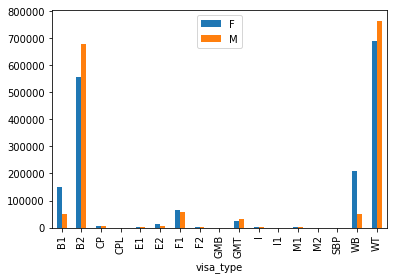

In [62]:
# Create temporary views for the DataFrames
immigrant_df.createOrReplaceTempView("immigrant")

qry = spark.sql("""
SELECT 
    gender, 
    visa_type,
    count(id) 
FROM immigrant
GROUP BY gender, visa_type
""")

df = qry.toPandas()
df = df.set_index(['visa_type', 'gender']).unstack()[[('count(id)', 'M'),('count(id)', 'F')]]
df.columns=['F', 'M']
df.plot(kind='bar');

In [64]:
# Find the top 5 cities with the highest percentage of foreign-born population
city_df.createOrReplaceTempView("city")
top_foreign_born_cities = spark.sql("""
    SELECT city_name, pct_foreign_born
    FROM city
    ORDER BY pct_foreign_born DESC
    LIMIT 5
""")
top_foreign_born_cities.show()

+------------+----------------+
|   city_name|pct_foreign_born|
+------------+----------------+
|Fayetteville|            13.9|
|Jacksonville|            12.3|
|Jacksonville|            12.3|
|     Norfolk|            12.0|
|    Columbus|            10.8|
+------------+----------------+



#### 4.2 Data Quality Checks
Explain the data quality checks you'll perform to ensure the pipeline ran as expected. These could include:
 * Integrity constraints on the relational database (e.g., unique key, data type, etc.)
 * Unit tests for the scripts to ensure they are doing the right thing
 * Source/Count checks to ensure completeness
 
Run Quality Checks

In [65]:
# Perform quality checks here

def table_exists(df):
    if df is not None:
        return True
    else:
        return False
        
if table_exists(immigrant_df) & table_exists(city_df) & table_exists(monthly_city_temp_df) & table_exists(time_df) & table_exists(immigration_fact_df):
    print("data quality check passed")
    print("dimension tables and fact table exist")
    print()
else:
    print("data quality check failed")
    print("table missing...")

data quality check passed
dimension tables and fact table exist



In [66]:
def table_not_empty(df):
    return df.count() != 0 

if table_not_empty(immigrant_df) & table_not_empty(city_df) & table_not_empty(monthly_city_temp_df) & table_not_empty(time_df) & table_not_empty(immigration_fact_df):
    print("data quality check passed!")
    print("dimension tables and fact table contain records")
    print()
else:
    print("data quality check failed!")
    print("null records...")

data quality check passed!
dimension tables and fact table contain records



#### 4.3 Data dictionary 
Create a data dictionary for your data model. For each field, provide a brief description of what the data is and where it came from. You can include the data dictionary in the notebook or in a separate file.

 **Fact Table**
  - immigration_fact_df - This data is sourced from the Immigration data
      - id - Unique ID
      - state_code - I94 Address
      - city_code - I94 Port
      - date - Arrival Date
      - count - Count
      
**Dimension Tables**      
 - immigrant_df - This data is sourced from the Immigration data
         - id - Unique ID
         - gender - Gender
         - age - I94 Bir
         - visa_type - Visa Type
     
 - city_df - This data is sourced from Demographics & Temprature data
  - city_code - City Code
  - state_code - State Code
  - city_name - City Name
  - median_age - Median Age
  - pct_male_pop - Percentage Male Population
  - pct_female_pop - Percentage Female Population
  - pct_veterans - Percentage of Veterans
  - pct_foreign_born - Percentage of Foreign Born
  - pct_native_american - American Indian and Alaska Native
  - pct_asian - Asian
  - pct_black - Black or African-American
  - pct_hispanic_or_latino - Hispanic or Latino
  - pct_white - Percentage White
  - total_pop - Total Population
  - lat - Latitude
  - long - Longitude
  
  
 - monthly_city_temp_df - This data is sourced from Temprature data
  - city_code - City Code
  - year - Year part of the date
  - month - Monthpart of the date
  - avg_temperature - Average Temprature
  
 - time_df - This data is sourced from the Immigration data
  - date - Arrival date
  - dayofweek - Day of the week of Arrival Date
  - weekofyear - Week of the Year of Arrival Date
  - month - Month of the arrival date

#### Step 5: Complete Project Write Up

Spark is chosen for this use case due to its ability to process large data sets in variety of format (SAS7BDAT,Parquet,CSV etc.) efficiently and also be able to scale the worker nodes. 

Data update cycle depends on the availability of the data and reporting frequency required by business.

**Solutions approaches for following scenarios** :

 **The data was increased by 100x** - If the data is increased multiple folds, we can consider instantiating EC2 nodes to host Spark nodes and scale up as required.
 
 **The data populates a dashboard that must be updated on a daily basis by 7am every day.**
 Orchestration tools such as Airflow can be used taking advantage of DAGs to write the data pipelines and schedule the jobs as per requirement.
 
 **The database needed to be accessed by 100+ people**
We can make use of Cloud infrastructure where in we can use Serverless instances of Redshift to create Facs/Dims tables and grant role based access to different users.
